In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pyarrow

## Imports

In [0]:
import os

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import math
import re

from numba import jit
from tqdm import tqdm
from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in
Here, I start working from the combined `df`.

In [5]:
labels_df = pd.read_feather(f'{PATH_LABELS}/labels_df')

labels_df.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [6]:
train_df = pd.read_feather(f'{PATH_FEATURES}/train')

# # UNCOMMENT
# test_df = pd.read_feather(f'{PATH_FEATURES}/test')

train_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454


In [7]:
len(train_df)

16135561

## EDA for a random `bookingID`

In [0]:
min_ids = (train_df.groupby('bookingID')['Speed'].count().reset_index(name='count')).query('count==120')['bookingID'].tolist()

labels_df[labels_df['bookingID'].isin(min_ids)]

danger0 = '927712936045'
danger1 = '317827579936' 
danger2 = '60129542207'
safe0 = '386547056705' 
safe1 = '343597383756'
safe2= '1288490188981' 

In [9]:
exclude = ['label', 'bookingID']

features = [c for c in train_df.columns if c not in exclude]

len(features)

10

In [0]:
def feature_plot(id):
    ex = train_df.query('bookingID == ' + id)
    ex = ex.reset_index(drop=True)
    ex[features].plot(subplots=True, sharex=True, figsize=(12,20))
    plt.show()   

In [0]:
# feature_plot(danger0)
# feature_plot(danger1)
# feature_plot(danger2)
# feature_plot(safe0)
# feature_plot(safe1)
# feature_plot(safe2)

In [0]:
# TODO
# take argmax of spikes

## Normalization
Before performing any feature engineering, each `bookingID` has a different reading for the features to begin with.Hence, it is safer to normalize these features before hand. For instance, as below, `acceleration_y` is always greater in magnitude compared to `acceleration_x` and `acceleration_z`. Taking the square of each term to get `total_a` doesn't help. Hence, I apply normalization to `acceleration` and `gyro` before any feature engineering.

In [13]:
ids = train_df['bookingID'].unique()

for id in ids[:5]:
  subset = train_df.query('bookingID == ' + str(id))
  mean_x = subset['acceleration_x'].mean() 
  mean_y = subset['acceleration_y'].mean() 
  mean_z = subset['acceleration_z'].mean()
  print('bookingID', str(id), ':', mean_x, mean_y, mean_z)

bookingID 0 : -0.7112635517500313 -9.613822152795066 -1.619658025612394
bookingID 1 : -0.5254063416347826 9.532086148061108 -2.1989990400493507
bookingID 2 : 0.30678641312615373 9.843182995897442 0.13934679782871795
bookingID 4 : -0.3651174820755256 -9.406438531125922 -2.613639003049303
bookingID 6 : 0.49061642717936066 9.538043043470333 2.355058993757808


In [0]:
features_to_norm = [
    'acceleration_x',
    'acceleration_y',
    'acceleration_z',
    'gyro_x',
    'gyro_y',
    'gyro_z'
]

Function to normalize.

In [0]:
def get_mean(df, col):
  
    print('Normalizing', col)
  
    id_mean = df.groupby('bookingID')[col].mean().reset_index(name=col+'_mean')
    
    id_mean = id_mean.rename(columns={'index': 'bookingID'})
    
    df = pd.merge(df, id_mean,
                  left_on='bookingID', right_on='bookingID',
                  how='inner')
    
    df[col] = df[col] - df[col+'_mean']
    
    df.drop(col+'_mean', axis=1, inplace=True)
    
    return df

In [16]:
for f in features_to_norm:
    train_df = get_mean(train_df, f)
    
# # UNCOMMENT    
# for f in features_to_norm:
#     test_df = get_mean(test_df, f)

Normalizing acceleration_x
Normalizing acceleration_y
Normalizing acceleration_z
Normalizing gyro_x
Normalizing gyro_y
Normalizing gyro_z


In [17]:
train_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,143.298294,1.529376,-0.327639,-0.395341,-0.019572,-0.087923,0.074920,0.0,3.442991
1,0,8.0,143.298294,1.257669,-0.221767,-0.419267,-0.050419,-0.072757,0.047375,1.0,0.228454
2,0,8.0,143.298294,-0.994944,0.343031,0.410210,-0.032293,-0.026534,0.019578,2.0,0.228454
3,0,8.0,143.298294,-0.705442,0.065791,-0.241319,-0.025741,0.011166,-0.021565,3.0,0.228454
4,0,8.0,143.298294,0.113119,-0.239712,0.241084,-0.017624,-0.040088,0.026089,4.0,0.228454


Interestingly, the `StandardScaler` by `sklearn` below took more than an hour to do the normalization by `bookingID`.

In [0]:
# def normalize_by_ids(df):
#     drivers = df['bookingID'].unique()
#     for driver in tqdm(drivers):
#         ids = df[df['bookingID'] == driver].index
#         scaler = StandardScaler(with_std=False)
#         df.loc[ids, features_to_norm] = scaler.fit_transform(df.loc[ids, features_to_norm])       

## Feature engineering
Some ideas are taken from this [discussion](https://www.kaggle.com/c/axa-driver-telematics-analysis/discussion/12848#latest-66913) and [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).

In [0]:
def total_a(df):
    # acceleration combining all directions
    total_a = np.power(df['acceleration_x'].values, 2) + \
                np.power(df['acceleration_y'].values, 2) + \
                np.power(df['acceleration_z'].values, 2)
    
    df['total_a'] = np.sqrt(total_a)
    
def total_gyro(df):
    # gyro combining all directions
    total_gyro = np.power(df['gyro_x'].values, 2) + \
                 np.power(df['gyro_y'].values, 2) + \
                 np.power(df['gyro_z'].values, 2)
    
    df['total_gyro'] = np.sqrt(total_gyro)
    
def roll(df):
    # roll  
    yz = df[['acceleration_y', 'acceleration_z']].values
    y, z = yz[:, 0], yz[:, 1]
       
    df['roll'] = np.arctan2(y, z)
    
def roll_gyro(df):
    # roll for gyro 
    yz = df[['gyro_y', 'gyro_z']].values
    y, z = yz[:, 0], yz[:, 1]
       
    df['roll_gyro'] = np.arctan2(y, z)
    
      
def pitch(df):
    # pitch
    xyz = df[['acceleration_x', 'acceleration_y', 'acceleration_z']].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    
    df['pitch'] = np.arctan2(-x, np.sqrt(np.power(y, 2) + np.power(z, 2)))

def pitch_gyro(df):
    # pitch
    xyz = df[['gyro_x', 'gyro_y', 'gyro_z']].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    
    df['pitch_gyro'] = np.arctan2(-x, np.sqrt(np.power(y, 2) + np.power(z, 2)))    
    
def horsepower(df):
    df['horsepower'] = df['total_a'] * df['Speed']
    
def xyz(df):
    df['xy'] = df['acceleration_x'] * df['acceleration_y']
    df['xz'] = df['acceleration_x'] * df['acceleration_z']
    df['yz'] = df['acceleration_y'] * df['acceleration_z']
    
def a_vs_gyro(df):
    df['a_vs_gyro_div'] = df['total_a'] / df['total_gyro']
  
def fe(df):
    total_a(df)
    total_gyro(df)
    roll(df)
    roll_gyro(df)
    pitch(df)
    pitch_gyro(df)
    xyz(df)
    horsepower(df)
    a_vs_gyro(df)

In [21]:
%%time
fe(train_df)

# # UNCOMMENT
# fe(test_df)

CPU times: user 10.1 s, sys: 2.69 s, total: 12.8 s
Wall time: 12.6 s


In [22]:
exclude = ['bookingID', 'second', 'Accuracy', 'Bearing']

features = [c for c in train_df.columns if c not in exclude]

len(features)

18

In [23]:
train_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,total_a,total_gyro,roll,roll_gyro,pitch,pitch_gyro,xy,xz,yz,horsepower,a_vs_gyro_div
0,0,12.0,143.298294,1.529376,-0.327639,-0.395341,-0.019572,-0.087923,0.074920,0.0,3.442991,1.613268,0.117160,-2.449566,-0.865076,-1.246888,0.167842,-0.501083,-0.604625,0.129529,5.554465,13.769757
1,0,8.0,143.298294,1.257669,-0.221767,-0.419267,-0.050419,-0.072757,0.047375,1.0,0.228454,1.344134,0.100399,-2.655061,-0.993618,-1.210159,0.526128,-0.278910,-0.527299,0.092980,0.307073,13.387890
2,0,8.0,143.298294,-0.994944,0.343031,0.410210,-0.032293,-0.026534,0.019578,2.0,0.228454,1.129538,0.046154,0.696446,-0.935130,1.077637,0.774938,-0.341296,-0.408136,0.140714,0.258048,24.473298
3,0,8.0,143.298294,-0.705442,0.065791,-0.241319,-0.025741,0.011166,-0.021565,3.0,0.228454,0.748473,0.035388,2.875432,2.663803,1.230058,0.814503,-0.046411,0.170237,-0.015877,0.170992,21.150487
4,0,8.0,143.298294,0.113119,-0.239712,0.241084,-0.017624,-0.040088,0.026089,4.0,0.228454,0.358301,0.050973,-0.782543,-0.993856,-0.321205,0.353040,-0.027116,0.027271,-0.057791,0.081855,7.029160


## Aggregate features

In [0]:
# =====================
# differentiation features
# =====================
def fo(x):
    return np.diff(x)

def so(x):
    return np.diff(fo(x))

def fo_min(x):
    # first order diff min
    return abs(np.min(fo(x)))

def so_min(x):
    # second order diff min
    return abs(np.min(so(x)))   

def fo_max(x):
    # first order diff max
    return np.max(fo(x))

def so_max(x):
    # second order diff max
    return np.max(so(x))  

def sign_change(x):
    return sum(np.diff(np.sign(x)) != 0)

In [0]:
import itertools
# =====================
# tsfresh functions
# =====================

def count_above_mean(x):
    m = np.mean(x)
    return np.where(x > m)[0].size

def absolute_sum_of_changes(x):
    return np.sum(np.abs(np.diff(x)))  
  
def kurtosis(x):
    if not isinstance(x, pd.Series):
        x = pd.Series(x)
    return pd.Series.kurtosis(x)  

def _get_length_sequences_where(x):
    if len(x) == 0:
        return [0]
    else:
        res = [len(list(group)) for value, group in itertools.groupby(x) if value == 1]
        return res if len(res) > 0 else [0]

def mean_abs_change(x):
    return np.mean(np.abs(np.diff(x)))
      
def longest_strike_above_mean(x):
    if not isinstance(x, (np.ndarray, pd.Series)):
        x = np.asarray(x)
    return np.max(_get_length_sequences_where(x >= np.mean(x))) if x.size > 0 else 0
  
def _roll(a, shift):
    if not isinstance(a, np.ndarray):
          a = np.asarray(a)
    idx = shift % len(a)
    return np.concatenate([a[-idx:], a[:-idx]])
  
def number_peaks(x, n=3):
    x_reduced = x[n:-n]

    res = None
    for i in range(1, n + 1):
        result_first = (x_reduced > _roll(x, i)[n:-n])

        if res is None:
            res = result_first
        else:
            res &= result_first

        res &= (x_reduced > _roll(x, -i)[n:-n])
    return np.sum(res)

In [0]:
def agg_features(df, new_df):
  
    # statistical features
    func = ['max', 'min', 'mean', 'std']
    
    # performed on all features
    features = [c for c in df.columns if c not in exclude]   
    
    for f in features:
        new = df.groupby('bookingID')[f].agg(func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
    
    print('Done statistical features...')
    
    gc.collect()
    
    subfeatures = ['acceleration_x', 'acceleration_y', 'acceleration_z',
                   'gyro_x', 'gyro_y', 'gyro_z',
                   'roll', 'pitch']

#     subfeatures = features
            
    print('Now to tsfresh features...')
    
    # ===
    # only perform tsfresh
    # features on the 6 important features
    # ===
    
    tsfresh_func = [count_above_mean, absolute_sum_of_changes,
                    kurtosis, mean_abs_change]

    for f in subfeatures:
        new = df.groupby('bookingID')[f].agg(tsfresh_func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
        
    print('Done tsfresh features...')
    
    gc.collect()
        
    print('Now to differentiation features...')
        
   
    diff_func = [fo_min, fo_max,
                 so_min, so_max,
                 sign_change]
        
    for f in subfeatures:
        new = df.groupby('bookingID')[f].agg(diff_func)
        
        new.columns = [f + "_" + c for c in new.columns]
        
        new.reset_index(drop=False, inplace=True)
        
        new_df = pd.merge(new_df, new,
                          left_on='bookingID', right_on='bookingID',
                          how='inner')
        
    print('Done differentiation features...')

                
    return new_df        

In [27]:
ids = train_df['bookingID'].unique()

agg_train = pd.DataFrame()
agg_train['bookingID'] = ids

print(len(agg_train))

# # UNCOMMENT
# test_ids = test_df['bookingID'].unique()
# agg_test = pd.DataFrame()
# agg_test['bookingID'] = test_ids

20000


In [29]:
%%time
agg_train = agg_features(train_df, agg_train)

# # UNCOMMENT
# agg_test = agg_features(train_df, agg_test)

Done statistical features...
Now to tsfresh features...
Done tsfresh features...
Now to differentiation features...
Done differentiation features...
CPU times: user 7min 35s, sys: 2.04 s, total: 7min 37s
Wall time: 7min 37s


In [43]:
num_sessions = train_df.groupby('bookingID')['second'].max().reset_index(name='max_sec')

num_sessions.head()

,bookingID,max_sec
0,0,1589.0
1,1,1034.0
2,2,825.0
3,4,1094.0
4,6,1094.0


In [44]:
num_counts = train_df.groupby('bookingID')['second'].count().reset_index(name='id_count')

num_counts.head()

,bookingID,id_count
0,0,1004
1,1,851
2,2,195
3,4,1094
4,6,1095


In [45]:
agg_train = pd.merge(agg_train, num_counts, 
                     left_on='bookingID', right_on='bookingID',
                     how='inner')

agg_train = pd.merge(agg_train, num_sessions, 
                     left_on='bookingID', right_on='bookingID',
                     how='inner')

agg_train.head()

,bookingID,acceleration_x_max,acceleration_x_min,acceleration_x_mean,acceleration_x_std,acceleration_y_max,acceleration_y_min,acceleration_y_mean,acceleration_y_std,acceleration_z_max,acceleration_z_min,acceleration_z_mean,acceleration_z_std,gyro_x_max,gyro_x_min,gyro_x_mean,gyro_x_std,gyro_y_max,gyro_y_min,gyro_y_mean,gyro_y_std,gyro_z_max,gyro_z_min,gyro_z_mean,gyro_z_std,Speed_max,Speed_min,Speed_mean,Speed_std,total_a_max,total_a_min,total_a_mean,total_a_std,total_gyro_max,total_gyro_min,total_gyro_mean,total_gyro_std,roll_max,roll_min,roll_mean,...,acceleration_x_so_min,acceleration_x_so_max,acceleration_x_sign_change,acceleration_y_fo_min,acceleration_y_fo_max,acceleration_y_so_min,acceleration_y_so_max,acceleration_y_sign_change,acceleration_z_fo_min,acceleration_z_fo_max,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_min,roll_fo_max,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_min,pitch_fo_max,pitch_so_min,pitch_so_max,pitch_sign_change,id_count,max_sec
0,0,5.493878,-3.981031,1.174359e-16,0.928022,3.493906,-3.150881,-4.663821e-15,0.639934,3.938515,-4.632149,-3.341727e-16,1.141266,0.435044,-0.395865,2.982204e-18,0.065954,0.475842,-0.603813,-8.950067e-18,0.100225,0.376995,-0.727704,-9.606636e-19,0.063685,22.946083,-1.0,8.994822,7.199919,5.743858,0.038603,1.307829,0.927958,0.745000,0.003087,0.100531,0.091292,3.139945,-3.133286,0.147859,...,11.454019,9.380850,459.0,3.691599,3.638962,6.821539,6.781763,495.0,5.173502,6.087766,9.125891,10.789780,465.0,0.525470,0.486405,0.972448,0.930134,507.0,0.629634,0.897888,1.315454,1.044398,434.0,0.568942,0.719506,0.698531,1.288449,492.0,6.107333,6.017383,11.741454,11.655533,495.0,2.719020,2.627917,5.007123,5.048010,459.0,1004,1589.0
1,1,4.338747,-4.827588,-1.095872e-17,0.744157,3.004070,-2.908661,-3.318928e-15,0.533915,3.680292,-3.156456,-3.061659e-15,0.854271,0.129004,-0.122900,-2.446144e-18,0.027740,0.478378,-0.670643,9.050731e-18,0.091699,0.234725,-0.121671,9.703036e-19,0.033838,21.882141,-1.0,7.881588,7.059362,4.857193,0.083211,0.998182,0.755694,0.710652,0.002591,0.066228,0.077018,3.137906,-3.137754,-0.062536,...,4.512639,4.369648,224.0,3.018927,3.398111,6.417038,5.309689,406.0,4.126713,3.441799,7.568512,5.746438,338.0,0.173800,0.238639,0.403154,0.299289,440.0,0.352295,0.372715,0.388964,0.472042,362.0,0.231692,0.206280,0.340217,0.347914,409.0,6.096989,6.115380,11.948457,12.212369,406.0,1.997294,2.090383,4.021613,3.433748,224.0,851,1034.0
2,2,1.649336,-3.278081,1.306647e-16,0.756589,3.490533,-1.901373,-5.543144e-15,0.505693,2.173523,-3.421898,2.163512e-17,1.020021,0.275704,-0.161676,3.513927e-18,0.053903,0.444556,-0.449139,-5.266443e-18,0.117321,0.253287,-0.128504,9.963540e-19,0.036215,9.360483,0.0,3.157213,2.897762,4.265758,0.068431,1.173949,0.695224,0.451528,0.005260,0.098022,0.091234,3.131622,-3.141110,-0.037292,...,5.854002,5.195576,59.0,4.379128,3.373533,7.752661,6.311308,101.0,4.683201,2.942564,5.363175,5.947378,53.0,0.396452,0.300546,0.665232,0.558331,84.0,0.347582,0.301157,0.391565,0.490525,40.0,0.332922,0.290161,0.623083,0.437990,90.0,6.181612,6.249883,12.431495,9.913982,101.0,1.739304,2.014826,3.136131,2.801048,59.0,195,825.0
3,4,2.384752,-2.501341,4.498230e-17,0.527220,2.341454,-9.441395,-7.258058e-16,0.598023,2.910020,-6.761230,7.712701e-18,0.779529,0.461616,-0.397623,-1.463574e-18,0.042342,0.629396,-0.529763,2.592888e-17,0.112567,0.505596,-0.347813,5.644987e-19,0.065927,19.780001,0.0,6.150996,5.595901,11.612716,0.049161,0.861174,0.707785,0.643006,0.002927,0.101539,0.092146,3.137615,-3.140683,0.468626,...,4.320099,4.670462,365.0,10.381845,8.948990,14.303281,19.330835,459.0,7.400095,6.435437,8.689844,13.835532,235.0,0.434474,0.484957,0.894047,0.838916,578.0,0.702851,0.701457,1.298823,1.169583,412.0,0.509004,0.616145,

Merge the aggregated `df` with labels.

In [46]:
agg_train = pd.merge(agg_train, labels_df,
                     left_on='bookingID', right_on='bookingID',
                     how='inner')

agg_train.head()

,bookingID,acceleration_x_max,acceleration_x_min,acceleration_x_mean,acceleration_x_std,acceleration_y_max,acceleration_y_min,acceleration_y_mean,acceleration_y_std,acceleration_z_max,acceleration_z_min,acceleration_z_mean,acceleration_z_std,gyro_x_max,gyro_x_min,gyro_x_mean,gyro_x_std,gyro_y_max,gyro_y_min,gyro_y_mean,gyro_y_std,gyro_z_max,gyro_z_min,gyro_z_mean,gyro_z_std,Speed_max,Speed_min,Speed_mean,Speed_std,total_a_max,total_a_min,total_a_mean,total_a_std,total_gyro_max,total_gyro_min,total_gyro_mean,total_gyro_std,roll_max,roll_min,roll_mean,...,acceleration_x_so_max,acceleration_x_sign_change,acceleration_y_fo_min,acceleration_y_fo_max,acceleration_y_so_min,acceleration_y_so_max,acceleration_y_sign_change,acceleration_z_fo_min,acceleration_z_fo_max,acceleration_z_so_min,acceleration_z_so_max,acceleration_z_sign_change,gyro_x_fo_min,gyro_x_fo_max,gyro_x_so_min,gyro_x_so_max,gyro_x_sign_change,gyro_y_fo_min,gyro_y_fo_max,gyro_y_so_min,gyro_y_so_max,gyro_y_sign_change,gyro_z_fo_min,gyro_z_fo_max,gyro_z_so_min,gyro_z_so_max,gyro_z_sign_change,roll_fo_min,roll_fo_max,roll_so_min,roll_so_max,roll_sign_change,pitch_fo_min,pitch_fo_max,pitch_so_min,pitch_so_max,pitch_sign_change,id_count,max_sec,label
0,0,5.493878,-3.981031,1.174359e-16,0.928022,3.493906,-3.150881,-4.663821e-15,0.639934,3.938515,-4.632149,-3.341727e-16,1.141266,0.435044,-0.395865,2.982204e-18,0.065954,0.475842,-0.603813,-8.950067e-18,0.100225,0.376995,-0.727704,-9.606636e-19,0.063685,22.946083,-1.0,8.994822,7.199919,5.743858,0.038603,1.307829,0.927958,0.745000,0.003087,0.100531,0.091292,3.139945,-3.133286,0.147859,...,9.380850,459.0,3.691599,3.638962,6.821539,6.781763,495.0,5.173502,6.087766,9.125891,10.789780,465.0,0.525470,0.486405,0.972448,0.930134,507.0,0.629634,0.897888,1.315454,1.044398,434.0,0.568942,0.719506,0.698531,1.288449,492.0,6.107333,6.017383,11.741454,11.655533,495.0,2.719020,2.627917,5.007123,5.048010,459.0,1004,1589.0,0
1,1,4.338747,-4.827588,-1.095872e-17,0.744157,3.004070,-2.908661,-3.318928e-15,0.533915,3.680292,-3.156456,-3.061659e-15,0.854271,0.129004,-0.122900,-2.446144e-18,0.027740,0.478378,-0.670643,9.050731e-18,0.091699,0.234725,-0.121671,9.703036e-19,0.033838,21.882141,-1.0,7.881588,7.059362,4.857193,0.083211,0.998182,0.755694,0.710652,0.002591,0.066228,0.077018,3.137906,-3.137754,-0.062536,...,4.369648,224.0,3.018927,3.398111,6.417038,5.309689,406.0,4.126713,3.441799,7.568512,5.746438,338.0,0.173800,0.238639,0.403154,0.299289,440.0,0.352295,0.372715,0.388964,0.472042,362.0,0.231692,0.206280,0.340217,0.347914,409.0,6.096989,6.115380,11.948457,12.212369,406.0,1.997294,2.090383,4.021613,3.433748,224.0,851,1034.0,1
2,2,1.649336,-3.278081,1.306647e-16,0.756589,3.490533,-1.901373,-5.543144e-15,0.505693,2.173523,-3.421898,2.163512e-17,1.020021,0.275704,-0.161676,3.513927e-18,0.053903,0.444556,-0.449139,-5.266443e-18,0.117321,0.253287,-0.128504,9.963540e-19,0.036215,9.360483,0.0,3.157213,2.897762,4.265758,0.068431,1.173949,0.695224,0.451528,0.005260,0.098022,0.091234,3.131622,-3.141110,-0.037292,...,5.195576,59.0,4.379128,3.373533,7.752661,6.311308,101.0,4.683201,2.942564,5.363175,5.947378,53.0,0.396452,0.300546,0.665232,0.558331,84.0,0.347582,0.301157,0.391565,0.490525,40.0,0.332922,0.290161,0.623083,0.437990,90.0,6.181612,6.249883,12.431495,9.913982,101.0,1.739304,2.014826,3.136131,2.801048,59.0,195,825.0,1
3,4,2.384752,-2.501341,4.498230e-17,0.527220,2.341454,-9.441395,-7.258058e-16,0.598023,2.910020,-6.761230,7.712701e-18,0.779529,0.461616,-0.397623,-1.463574e-18,0.042342,0.629396,-0.529763,2.592888e-17,0.112567,0.505596,-0.347813,5.644987e-19,0.065927,19.780001,0.0,6.150996,5.595901,11.612716,0.049161,0.861174,0.707785,0.643006,0.002927,0.101539,0.092146,3.137615,-3.140683,0.468626,...,4.670462,365.0,10.381845,8.948990,14.303281,19.330835,459.0,7.400095,6.435437,8.689844,13.835532,235.0,0.434474,0.484957,0.894047,0.838916,578.0,0.702851,0.701457,1.298823,1.169583,412.0,0.509004,0.616145,1.086375,0.714633,490.0,6.181050,6.225528,11.23

In [0]:
agg_train.to_feather(f'{PATH_FEATURES}/agg_train-3')

# # UNCOMMENT
# agg_test.to_feather(f'{PATH_FEATURES}/agg_test')

## Aggregated features EDA 

In [0]:
# agg_train = pd.read_feather(f'{PATH_FEATURES}/agg_train')

train_df = agg_train.copy()

In [0]:
gc.collect()

112

In [0]:
cols = [c for c in train_df.columns if 'max' in c]

len(cols)

33

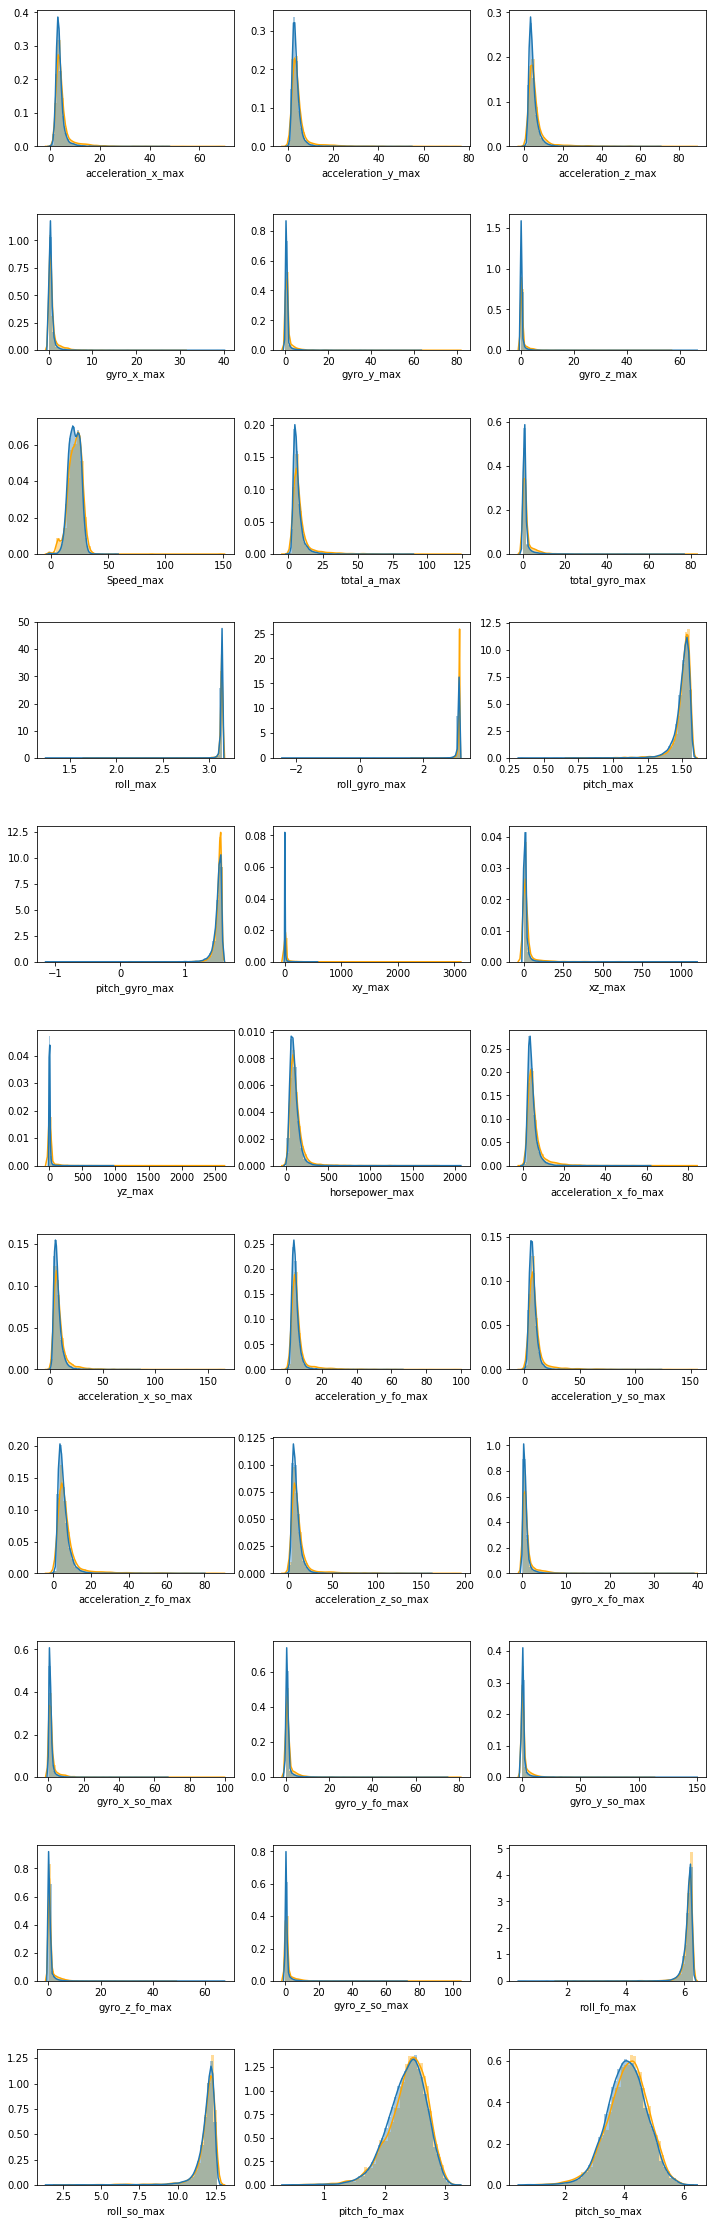

In [0]:
plt.figure(figsize=(12,40))
for i, col in enumerate(cols):
    plt.subplot(11, 3, i+1)
    sns.distplot(train_df[train_df['label']==1][col],color ='orange')
    sns.distplot(train_df[train_df['label']==0][col])
    plt.subplots_adjust(hspace=0.5)
plt.show()

In [0]:
features = [c for c in train_df.columns if c not in ['bookingID', 'label']]

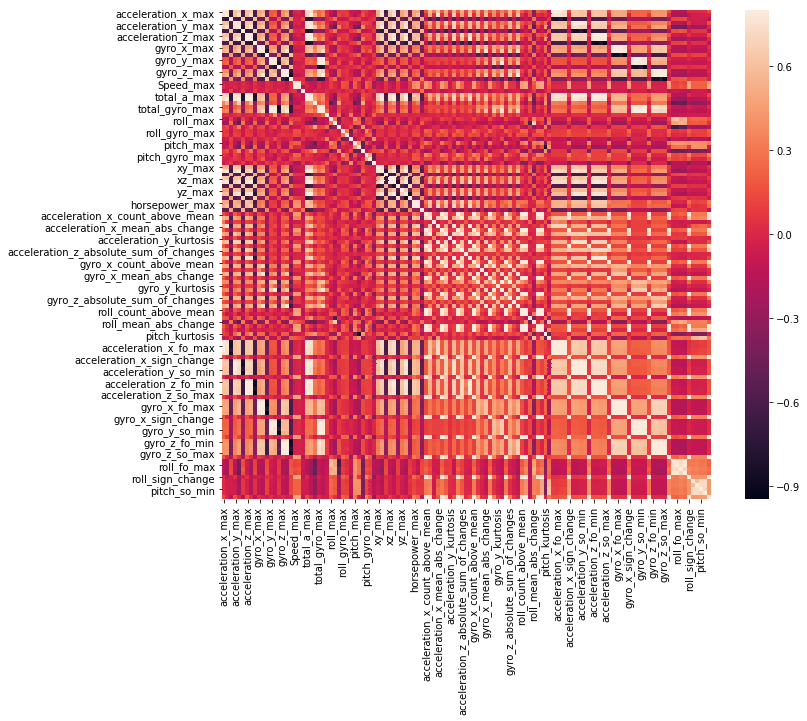

In [0]:
corr_mat = train_df[features].corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=.8, square=True);

Check for outliers according to Chauvenet's criterion.

In [0]:
from scipy.special import erfc

def chauvenet(array):
    mean = array.mean()           # Mean of incoming array
    stdv = array.std()            # Standard deviation
    N = len(array)                # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(array-mean)/stdv      # Distance of a value to mean in stdv's
    prob = erfc(d)                # Area normal dist.    
    return prob < criterion       # Use boolean array outside this function

In [0]:
train_outliers = dict()

for col in features:
    train_outliers[col] = train_df[chauvenet(train_df[col].values)].shape[0]    

Create a dataframe for outliers.

In [0]:
outliers_df = pd.DataFrame.from_dict(train_outliers,
                                     orient='index')

outliers_df = outliers_df.reset_index()

outliers_df = outliers_df.rename(columns={'index': 'feature',
                                           0: 'num_outliers'})

outliers_df = outliers_df.sort_values('num_outliers', ascending=False)

outliers_df = outliers_df[:50]

outliers_df.head()

,feature,num_outliers
78,roll_mean_abs_change,521
4,acceleration_y_std,507
22,total_a_std,502
28,roll_std,439
25,total_gyro_std,432


Plot the `outliers_df`.

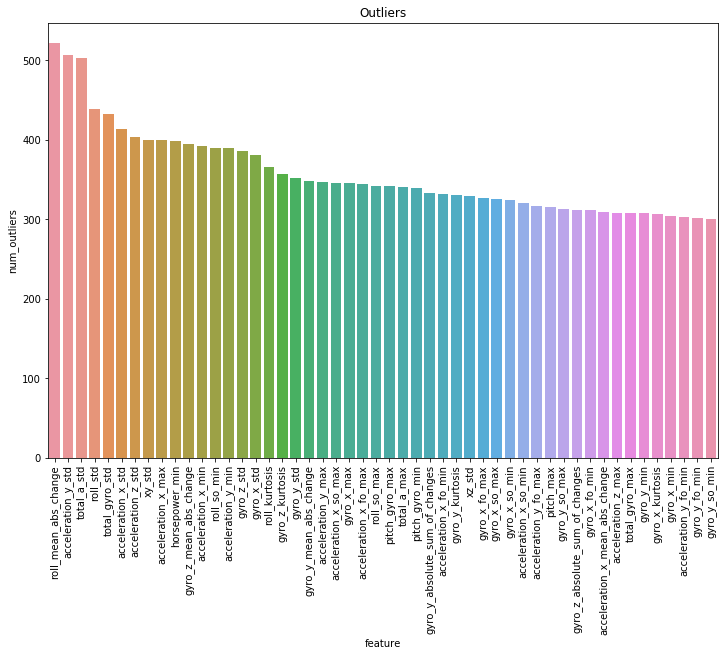

In [0]:
plt.figure(figsize=(12,8))
sns.barplot(x="feature", y="num_outliers", 
            data=outliers_df)
plt.xticks(rotation=90)
plt.title('Outliers')
plt.show()